
# Telco Customer Churn — Data Analyst Notebook
**Goal:** Explore the Telco customer dataset to **find churn drivers** and present **clear, business-ready insights**.  
**Focus:** Data cleaning → EDA → Feature engineering for analysis → KPIs & insights.  


In [35]:

# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 100)
plt.rcParams['figure.figsize'] = (8,4)
sns.set_context('notebook')



## 1. Load Data
- Load the Telco churn dataset
- Set `customerID` as index
- Quick peek at shape and columns


In [36]:
# Load data from a stable public source with local fallback
import io, sys, os, pandas as pd
from pathlib import Path

GITHUB_RAW = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/WA_Fn-UseC_-Telco-Customer-Churn.csv"
LOCAL_PATHS = [
    Path("./WA_Fn-UseC_-Telco-Customer-Churn.csv"),
    Path("./Telco-Customer-Churn.csv"),
    Path("./telco_churn.csv"),
    Path("./data/WA_Fn-UseC_-Telco-Customer-Churn.csv"),
]

def load_telco_df():
    # 1) Try GitHub RAW
    try:
        return pd.read_csv(GITHUB_RAW)
    except Exception as e:
        print(f"[Info] Online load failed: {e}", file=sys.stderr)
    # 2) Try local files
    for p in LOCAL_PATHS:
        if p.exists():
            print(f"✅ Loading local file: {p}")
            return pd.read_csv(p)
    raise FileNotFoundError("Place the CSV beside the notebook (e.g., WA_Fn-UseC_-Telco-Customer-Churn.csv).")

df = load_telco_df()
df.set_index("customerID", inplace=True)


✅ Loading local file: WA_Fn-UseC_-Telco-Customer-Churn.csv


[Info] Online load failed: HTTP Error 404: Not Found



## 2. Data Quality & Cleaning
- Fix dtypes (`TotalCharges` can come as string; coerce to numeric)
- Check missing values and impute logically
- Remove obvious duplicates if any


In [49]:
# Coerce TotalCharges to numeric and fill NaNs for tenure==0
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"].astype(str).str.strip(), errors="coerce")
mask_new = df["TotalCharges"].isna() & (df["tenure"] == 0)
df.loc[mask_new, "TotalCharges"] = df.loc[mask_new, "MonthlyCharges"]


In [50]:

# Re-check remaining NaNs
df.isna().sum().sort_values(ascending=False).head(10)


,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


In [51]:

# Duplicates (should be none, but check)
dup_count = df.index.duplicated().sum()
dup_count


np.int64(0)


## 3. Quick KPIs
- Overall churn rate
- Distribution by contract types / payment methods


In [40]:

# Create a numeric churn flag for convenience
df['ChurnFlag'] = (df['Churn'] == 'Yes').astype(int)

overall_churn_rate = df['ChurnFlag'].mean()
by_contract = df.groupby('Contract')['ChurnFlag'].mean().sort_values(ascending=False)
by_payment = df.groupby('PaymentMethod')['ChurnFlag'].mean().sort_values(ascending=False)

overall_churn_rate, by_contract.head(3), by_payment.head(3)


(np.float64(0.2653698707936959),
 Contract
 Month-to-month    0.427097
 One year          0.112695
 Two year          0.028319
 Name: ChurnFlag, dtype: float64,
 PaymentMethod
 Electronic check             0.452854
 Mailed check                 0.191067
 Bank transfer (automatic)    0.167098
 Name: ChurnFlag, dtype: float64)


## 4. Feature Engineering (for Analysis Only)
- **AverageCharges:** `TotalCharges / tenure` (fallback to `TotalCharges` when tenure=0)
- **HighSpender:** `MonthlyCharges` > mean(`AverageCharges`)
- **ServicesMost:** average of service usage (0/1) across selected columns


In [41]:

# AverageCharges
df['AverageCharges'] = df['TotalCharges'] / df['tenure'].replace(0, np.nan)
df.loc[df['tenure'] == 0, 'AverageCharges'] = df.loc[df['tenure'] == 0, 'TotalCharges']

# HighSpender flag
avg_mean = df['AverageCharges'].mean()
df['HighSpender'] = (df['MonthlyCharges'] > avg_mean).astype(int)

# Service usage intensity (ServicesMost)
# Convert Yes/No service columns to 1/0 then average
service_cols_yesno = [
    'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'PhoneService', 'PaperlessBilling'
]

tmp = df[service_cols_yesno].replace({'Yes':1, 'No':0, 'No internet service':0, 'No phone service':0})
df['ServicesMost'] = tmp.mean(axis=1)

df[['AverageCharges','HighSpender','ServicesMost']].head(3)


/tmp/ipython-input-2729616740.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tmp = df[service_cols_yesno].replace({'Yes':1, 'No':0, 'No internet service':0, 'No phone service':0})


,AverageCharges,HighSpender,ServicesMost
customerID,,,
7590-VHVEG,29.850000,0,0.222222
5575-GNVDE,55.573529,0,0.333333
3668-QPYBK,54.075000,0,0.444444



## 5. Exploratory Data Analysis (EDA)
**Questions:**  
- Do certain **contracts** churn more?  
- Do **payment methods** correlate with churn?  
- How do **MonthlyCharges** and **tenure** differ by churn?  
- Are **HighSpenders** more likely to churn?


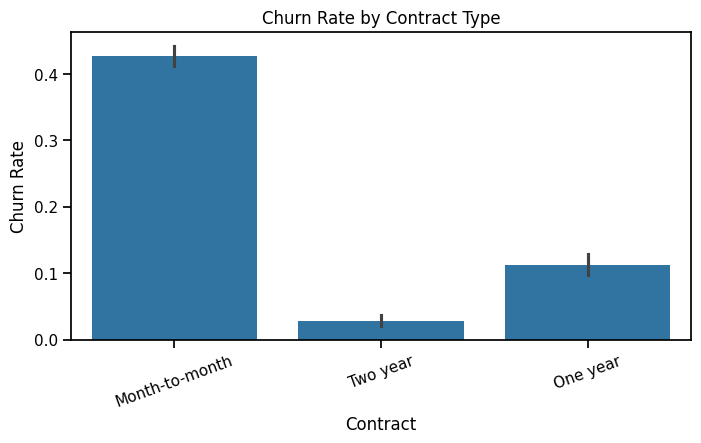

In [42]:

# Churn rate by Contract
order = df['Contract'].value_counts().index
sns.barplot(x='Contract', y='ChurnFlag', data=df, order=order)
plt.title('Churn Rate by Contract Type'); plt.ylabel('Churn Rate'); plt.xlabel('Contract'); plt.xticks(rotation=20); plt.show()


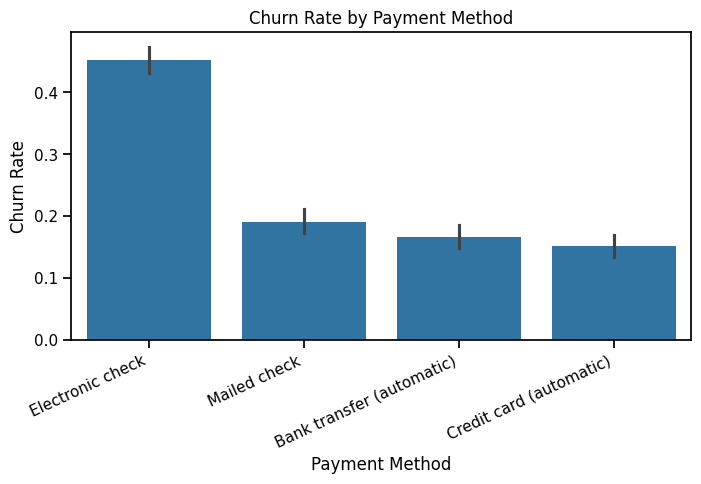

In [43]:

# Churn rate by Payment Method
order = df['PaymentMethod'].value_counts().index
sns.barplot(x='PaymentMethod', y='ChurnFlag', data=df, order=order)
plt.title('Churn Rate by Payment Method'); plt.ylabel('Churn Rate'); plt.xlabel('Payment Method'); plt.xticks(rotation=25, ha='right'); plt.show()


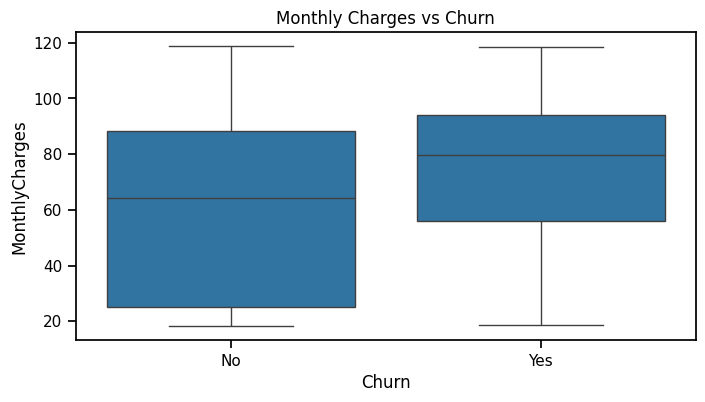

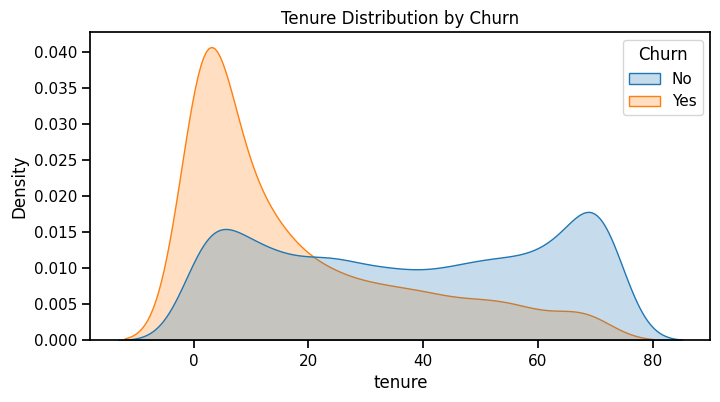

In [44]:

# MonthlyCharges distribution by churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges vs Churn'); plt.show()

# Tenure distribution by churn
sns.kdeplot(data=df, x='tenure', hue='Churn', common_norm=False, fill=True)
plt.title('Tenure Distribution by Churn'); plt.show()


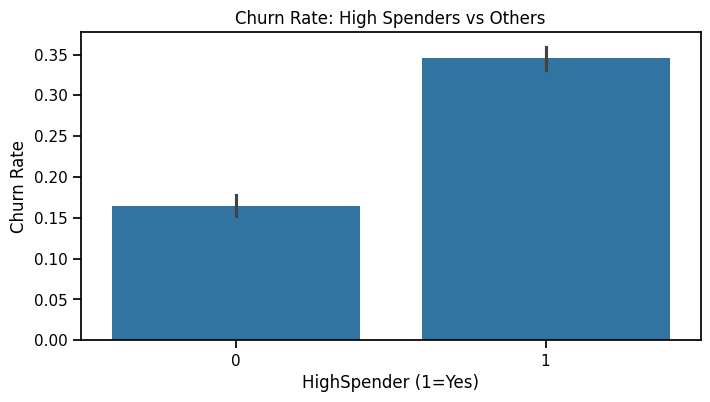

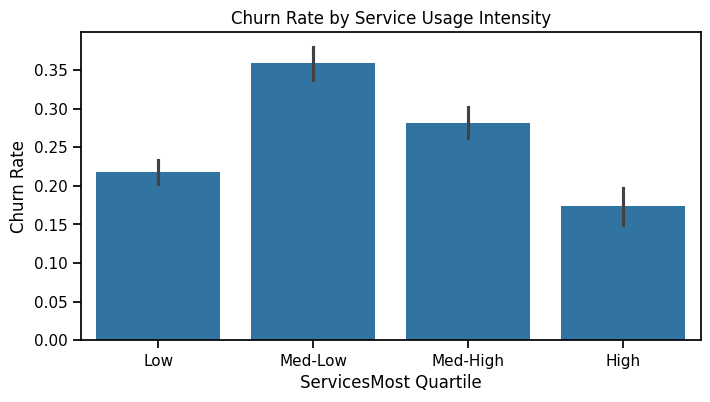

In [45]:

# HighSpender vs Churn
sns.barplot(x='HighSpender', y='ChurnFlag', data=df, estimator=np.mean)
plt.title('Churn Rate: High Spenders vs Others'); plt.xlabel('HighSpender (1=Yes)'); plt.ylabel('Churn Rate'); plt.show()

# ServicesMost vs Churn (binned)
bins = pd.qcut(df['ServicesMost'], 4, labels=['Low','Med-Low','Med-High','High'])
sns.barplot(x=bins, y='ChurnFlag', data=df, estimator=np.mean, order=['Low','Med-Low','Med-High','High'])
plt.title('Churn Rate by Service Usage Intensity'); plt.xlabel('ServicesMost Quartile'); plt.ylabel('Churn Rate'); plt.show()



## 6. Correlation Overview (Numeric)


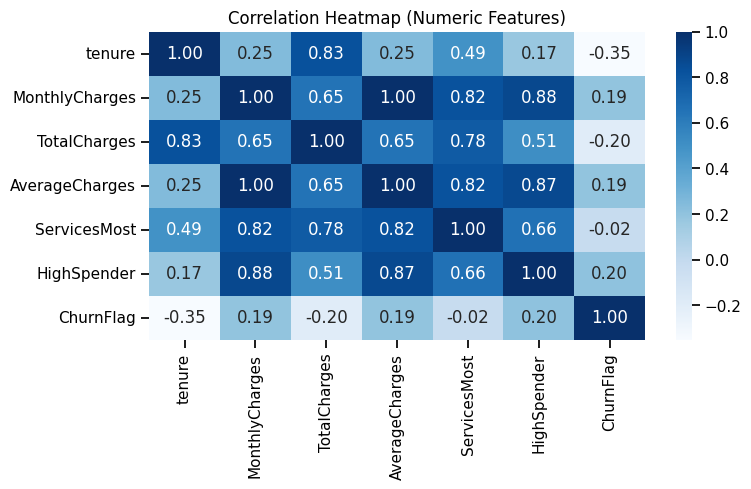

In [46]:

num_cols = ['tenure','MonthlyCharges','TotalCharges','AverageCharges','ServicesMost','HighSpender','ChurnFlag']
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues')
plt.title('Correlation Heatmap (Numeric Features)'); plt.show()



## 7. Business-Facing Summaries


In [47]:

summary = {
    'Overall Churn Rate': round(df['ChurnFlag'].mean(), 3),
    'MTM vs 1yr vs 2yr (churn)': df.groupby('Contract')['ChurnFlag'].mean().sort_values(ascending=False).round(3).to_dict(),
    'Payment Method (churn)': df.groupby('PaymentMethod')['ChurnFlag'].mean().sort_values(ascending=False).round(3).to_dict(),
    'HighSpender (1) churn rate': round(df.loc[df['HighSpender']==1, 'ChurnFlag'].mean(), 3),
    'LowSpender (0) churn rate': round(df.loc[df['HighSpender']==0, 'ChurnFlag'].mean(), 3),
}
summary


{'Overall Churn Rate': np.float64(0.265),
 'MTM vs 1yr vs 2yr (churn)': {'Month-to-month': 0.427,
  'One year': 0.113,
  'Two year': 0.028},
 'Payment Method (churn)': {'Electronic check': 0.453,
  'Mailed check': 0.191,
  'Bank transfer (automatic)': 0.167,
  'Credit card (automatic)': 0.152},
 'HighSpender (1) churn rate': np.float64(0.345),
 'LowSpender (0) churn rate': np.float64(0.165)}


## 8. Key Insights (Explain Like a DA)
- **Contract matters:** Month-to-month contracts have **significantly higher churn** than 1–2 year contracts.  
- **Billing & Payments:** Electronic check users tend to churn **more** than auto-pay methods.  
- **Tenure:** Newer customers (low tenure) churn more; longer-tenure customers are stickier.  
- **Spend:** Higher monthly charges tend to be associated with higher churn; **HighSpenders** are riskier.  
- **Service breadth:** Customers using more services (higher **ServicesMost**) often churn less (they're more “locked in”), but confirm with the plot above.



## 9. Export Clean Data for Dashboard (Power BI / Tableau / Excel)


In [48]:

export_cols = ['gender','SeniorCitizen','Partner','Dependents','tenure','PhoneService','MultipleLines','InternetService',
               'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
               'Contract','PaperlessBilling','PaymentMethod','MonthlyCharges','TotalCharges','Churn','ChurnFlag',
               'AverageCharges','HighSpender','ServicesMost']

clean_path = 'telco_clean_DA.csv'
df[export_cols].to_csv(clean_path, index=True)
print(f"✅ Exported: {clean_path}")


✅ Exported: telco_clean_DA.csv



## 10. Next Steps (Optional)
- Build a **Power BI** or **Tableau** dashboard using `telco_clean_DA.csv`  
- Create cohorts (e.g., by first month on service) to track churn over time  
- Segment by **Contract + PaymentMethod + Tenure bucket** to target retention offers  
- Add **confidence intervals** to churn rate estimates for robustness


 ## 11. Key Business Insights from Churn Analysis



In [54]:
# Pretty Insights (Markdown rendering)
from IPython.display import display, Markdown
import pandas as pd
import numpy as np

def churn_insights_markdown(df):
    churn_rate = df['ChurnFlag'].mean() * 100

    contract_churn = df.groupby('Contract')['ChurnFlag'].mean().sort_values(ascending=False) * 100
    top_contract = contract_churn.index[0]

    pay_churn = df.groupby('PaymentMethod')['ChurnFlag'].mean().sort_values(ascending=False) * 100
    risky_pay = pay_churn.index[0]

    low_tenure_churn = df.loc[df['tenure'] < 12, 'ChurnFlag'].mean() * 100

    high_spender_churn = df.loc[df['HighSpender']==1, 'ChurnFlag'].mean() * 100
    low_spender_churn  = df.loc[df['HighSpender']==0, 'ChurnFlag'].mean() * 100

    # ServicesMost quartiles (guard against ties/constant)
    try:
        bins = pd.qcut(df['ServicesMost'], 4, labels=['Low','Med-Low','Med-High','High'])
        service_churn = df.groupby(bins, observed=True)['ChurnFlag'].mean() * 100
        low_services = float(service_churn.get('Low', np.nan))
        high_services = float(service_churn.get('High', np.nan))
        services_line = f"Customers with **low service usage** churn more (**{low_services:.1f}%**) than heavy users (**{high_services:.1f}%**)." \
                        if pd.notna(low_services) and pd.notna(high_services) else \
                        "Customers using more services generally churn less (see plots)."
    except Exception:
        services_line = "Customers using more services generally churn less (see plots)."

    md = f"""
### Key Insights from Churn Analysis

1. Overall churn rate is **{churn_rate:.1f}%** across all customers.
2. Customers on **{top_contract}** contracts churn the most (**{contract_churn.iloc[0]:.1f}%**).
3. **{risky_pay}** users have the highest churn among payment methods (**{pay_churn.iloc[0]:.1f}%**).
4. Customers with **tenure < 12 months** churn at **{low_tenure_churn:.1f}%**, much higher than long-tenure customers.
5. **High spenders** churn at **{high_spender_churn:.1f}%** vs **{low_spender_churn:.1f}%** for low spenders.
6. {services_line}
"""
    display(Markdown(md))

# Run it
churn_insights_markdown(df)



### Key Insights from Churn Analysis

1. Overall churn rate is **26.5%** across all customers.
2. Customers on **Month-to-month** contracts churn the most (**42.7%**).
3. **Electronic check** users have the highest churn among payment methods (**45.3%**).
4. Customers with **tenure < 12 months** churn at **48.3%**, much higher than long-tenure customers.
5. **High spenders** churn at **34.5%** vs **16.5%** for low spenders.
6. Customers with **low service usage** churn more (**21.8%**) than heavy users (**17.4%**).
